In [2]:
import warnings
warnings.filterwarnings('ignore')
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('read_csv').getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [3]:
t = spark.read.csv('./train.csv', header=True, inferSchema=True)
t.show()

+----------+-----+----+-----+
|      date|store|item|sales|
+----------+-----+----+-----+
|2013-01-01|    1|   1|   13|
|2013-01-02|    1|   1|   11|
|2013-01-03|    1|   1|   14|
|2013-01-04|    1|   1|   13|
|2013-01-05|    1|   1|   10|
|2013-01-06|    1|   1|   12|
|2013-01-07|    1|   1|   10|
|2013-01-08|    1|   1|    9|
|2013-01-09|    1|   1|   12|
|2013-01-10|    1|   1|    9|
|2013-01-11|    1|   1|    9|
|2013-01-12|    1|   1|    7|
|2013-01-13|    1|   1|   10|
|2013-01-14|    1|   1|   12|
|2013-01-15|    1|   1|    5|
|2013-01-16|    1|   1|    7|
|2013-01-17|    1|   1|   16|
|2013-01-18|    1|   1|    7|
|2013-01-19|    1|   1|   18|
|2013-01-20|    1|   1|   15|
+----------+-----+----+-----+
only showing top 20 rows



In [4]:
# date column에서 년, 월, 주차 추출
import pyspark.sql.functions as F

t = t.withColumn('year', F.date_format(F.col('date'), 'y').cast("int"))\
        .withColumn('month', F.date_format(F.col('date'), 'M').cast("int"))\
            .withColumn('week', F.date_format(F.col('date'), 'W').cast("int"))

In [5]:
t.printSchema()

root
 |-- date: string (nullable = true)
 |-- store: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- sales: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week: integer (nullable = true)



In [6]:
t.show(5)

+----------+-----+----+-----+----+-----+----+
|      date|store|item|sales|year|month|week|
+----------+-----+----+-----+----+-----+----+
|2013-01-01|    1|   1|   13|2013|    1|   1|
|2013-01-02|    1|   1|   11|2013|    1|   1|
|2013-01-03|    1|   1|   14|2013|    1|   1|
|2013-01-04|    1|   1|   13|2013|    1|   1|
|2013-01-05|    1|   1|   10|2013|    1|   1|
+----------+-----+----+-----+----+-----+----+
only showing top 5 rows



In [7]:
# 주 단위 데이터 생성(DataFrame 활용)
t.createOrReplaceTempView('rawdf')
# week_it_df = t.groupBy(['year', 'month', 'week', 'item']).agg(sum('sales').alias('week_sales')).orderBy(['year','month','week','item'])
week_si_df = t.groupBy(['year', 'month', 'week', 'store', 'item'])\
    .agg(F.sum('sales').alias('week_sales'), F.first('date').alias('week_stdate')
    ).orderBy(['week_stdate','store','item'])

In [8]:
st_si = week_si_df.groupBy(['store','item']).agg(F.array_sort(F.collect_list(F.struct('week_stdate','week_sales'))).getItem('week_sales').alias('sales'))


In [9]:
import numpy as np
from pyspark.sql.types import *

@F.udf(returnType=ArrayType(IntegerType()))
def fake(ary):
    #ary = np.array(ary)

    print(ary[0])
    print(ary[1])
    
    fake_value = np.array(ary[-1])

    if (ary[0]*ary[1]) % 3 == 0:    
        fake_value[:60] = 0
    
    elif (ary[0]*ary[1]) % 3 == 1:
        fake_value[101:160] = 0
    
    else:
        fake_value[260:] = 0

    return fake_value.tolist()


# @F.udf(returnType=ArrayType(FloatType()))
# def mmscale(row):
#     ary = np.array(row)
#     scaled = (ary-ary.min())/(ary.max()-ary.min())
    
#     return scaled.tolist()

mmscale = F.udf(lambda x: ((np.array(x)-np.min(x))/(np.max(x)-np.min(x))).tolist(),ArrayType(FloatType()))

In [10]:
st_si_week = st_si.withColumn('fake_sales', fake(F.struct('store', 'item', 'sales')))\
    .withColumn('scaled_fake_sales', mmscale('fake_sales'))

In [11]:
st_si_week.show()

+-----+----+--------------------+--------------------+--------------------+
|store|item|               sales|          fake_sales|   scaled_fake_sales|
+-----+----+--------------------+--------------------+--------------------+
|    1|   1|[61, 68, 75, 73, ...|[61, 68, 75, 73, ...|[0.29326922, 0.32...|
|    1|   2|[151, 221, 206, 1...|[151, 221, 206, 1...|[0.27554744, 0.40...|
|    1|   3|[92, 120, 120, 13...|[0, 0, 0, 0, 0, 0...|[0.0, 0.0, 0.0, 0...|
|    1|   4|[60, 87, 61, 78, ...|[60, 87, 61, 78, ...|[0.2764977, 0.400...|
|    1|   5|[42, 67, 57, 52, ...|[42, 67, 57, 52, ...|[0.2413793, 0.385...|
|    1|   6|[135, 224, 198, 2...|[0, 0, 0, 0, 0, 0...|[0.0, 0.0, 0.0, 0...|
|    1|   7|[156, 204, 230, 2...|[156, 204, 230, 2...|[0.2831216, 0.370...|
|    1|   8|[213, 285, 272, 2...|[213, 285, 272, 2...|[0.3, 0.40140846,...|
|    1|   9|[117, 188, 182, 1...|[0, 0, 0, 0, 0, 0...|[0.0, 0.0, 0.0, 0...|
|    1|  10|[183, 265, 244, 2...|[183, 265, 244, 2...|[0.26911765, 0.38...|
|    1|  11|

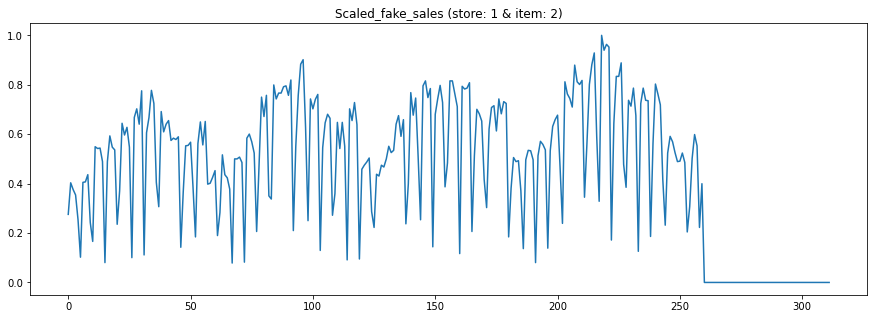

Stationary Test(ADFuller)
Scaled_fake_sales (store: 1 & item: 2)
ADF Statistic: -1.266195
p-value: 0.644493
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


Stationary Test(KPSS)
KPSS Statistic: 0.888569
p-value: 0.010000
lag: 10.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


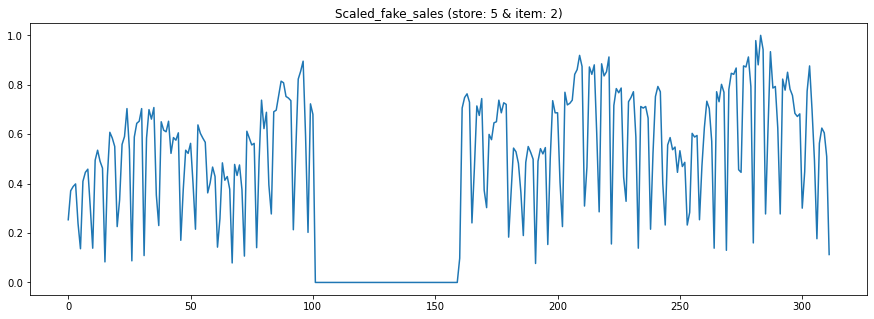

Stationary Test(ADFuller)
Scaled_fake_sales (store: 5 & item: 2)
ADF Statistic: -2.636970
p-value: 0.085595
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


Stationary Test(KPSS)
KPSS Statistic: 0.694086
p-value: 0.014083
lag: 10.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


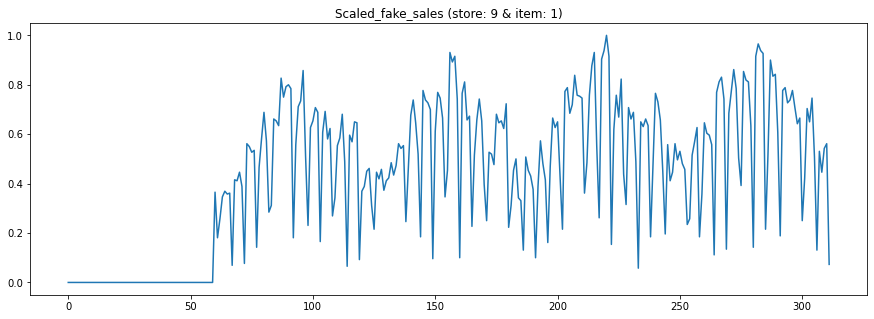

Stationary Test(ADFuller)
Scaled_fake_sales (store: 9 & item: 1)
ADF Statistic: -2.406049
p-value: 0.140037
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


Stationary Test(KPSS)
KPSS Statistic: 1.676629
p-value: 0.010000
lag: 10.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


In [12]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

for i in [1,201,400]:
    fig = plt.figure(figsize=(15,5))
    plt.plot(np.array(st_si_week.collect()[i].scaled_fake_sales))
    plt.title(f'Scaled_fake_sales (store: {st_si_week.collect()[i].store} & item: {st_si_week.collect()[i].item})')
    plt.show()

    adf_result = adfuller(st_si_week.collect()[i].scaled_fake_sales)
    print('Stationary Test(ADFuller)')
    print(f'Scaled_fake_sales (store: {st_si_week.collect()[i].store} & item: {st_si_week.collect()[i].item})')
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')
    
    kpss_result = kpss(st_si_week.collect()[i].scaled_fake_sales)
    print('Stationary Test(KPSS)')
    print('KPSS Statistic: %f' % kpss_result[0]) # 통계량
    print('p-value: %f' % kpss_result[1])       # p-value 값
    print('lag: %f' % kpss_result[2])           # lag 값
    print('Critical Values:')
    for key, value in kpss_result[3].items():   # 유의 수준에 따른 값
 	    print('\t%s: %.3f' % (key, value))


In [13]:
# B-spline coefficent 계산을 위한 라이브러리 import
import numpy as np
from scipy.interpolate import BSpline
import pyspark.sql.functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
# B-Spline에 대한 UDF 생성
#@F.udf(returnType=)
def basis_bspline(cp_cnt, knots_cnt):
    x = np.linspace(0, 1, cp_cnt) # 데이터 기간과 같은 time 공간 생성
    these_knots = np.linspace(0,1,knots_cnt-2) # 나누고자 하는 knot의 갯수 만큼 생성
    numpyknots = np.concatenate(([0,0,0],these_knots,[1,1,1])) # python BSpline은 앞뒤로 3개씩 knots를 무시하므로 추가
    y_py = np.zeros((x.shape[0], knots_cnt))#len(these_knots)+2)) # B-Spline의 basis를 위한 numpy.array 생성(time공간 x knots갯수+2)
    for i in range(len(these_knots)+2):
        y_py[:,i] = BSpline(numpyknots, (np.arange(len(these_knots)+2)==i).astype(float), 3, extrapolate=False)(x) # time 특성에 따른 basis 생성 (time공간 x knots갯수+2)

    plt.plot(x,y_py) # B-Spline basis plot
    plt.title('In SciPy')

    return y_py

def cvt_bspline(basis):
    return F.udf(lambda row: np.dot(np.dot(np.linalg.inv(np.dot(basis.T,basis)),basis.T),np.array(np.array(row)).T).T.tolist(), ArrayType(FloatType()))


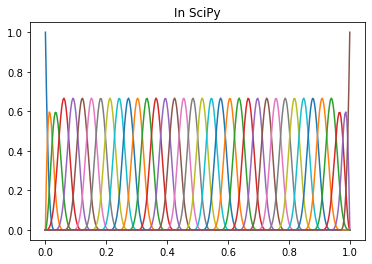

In [15]:
basis = basis_bspline(312,36)
st_si_week = st_si_week.withColumn('bs_fake_sales', cvt_bspline(basis) (F.col('scaled_fake_sales')))

In [16]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import ClusteringEvaluator

to_vector = F.udf(lambda a: Vectors.dense(a), VectorUDT())
t_kmeans = st_si_week.select('store', 'item', 'scaled_fake_sales', to_vector('bs_fake_sales').alias('bs_fake_sales'))
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='bs_fake_sales', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='bs_fake_sales', k=i)
    KMeans_fit=KMeans_algo.fit(t_kmeans)
    output=KMeans_fit.transform(t_kmeans)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.7263410278836564
Silhouette Score: 0.9848555015960849
Silhouette Score: 0.8386016167043775
Silhouette Score: 0.5322658011097123
Silhouette Score: 0.38076041225209867
Silhouette Score: 0.3461137460650082
Silhouette Score: 0.2790254329351519
Silhouette Score: 0.375438040799138


Text(0, 0.5, 'cost')

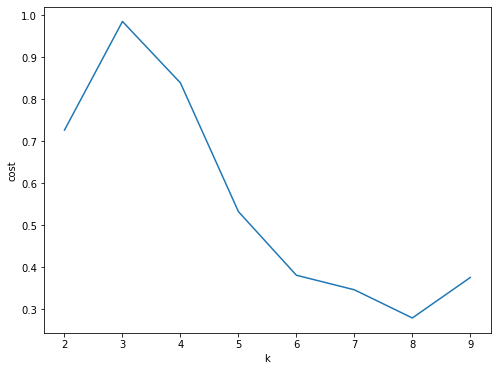

In [17]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [19]:
KMeans_fin=KMeans(featuresCol='bs_fake_sales', k=3)
KMeans_fit=KMeans_fin.fit(t_kmeans)
output_fin=KMeans_fit.transform(t_kmeans)

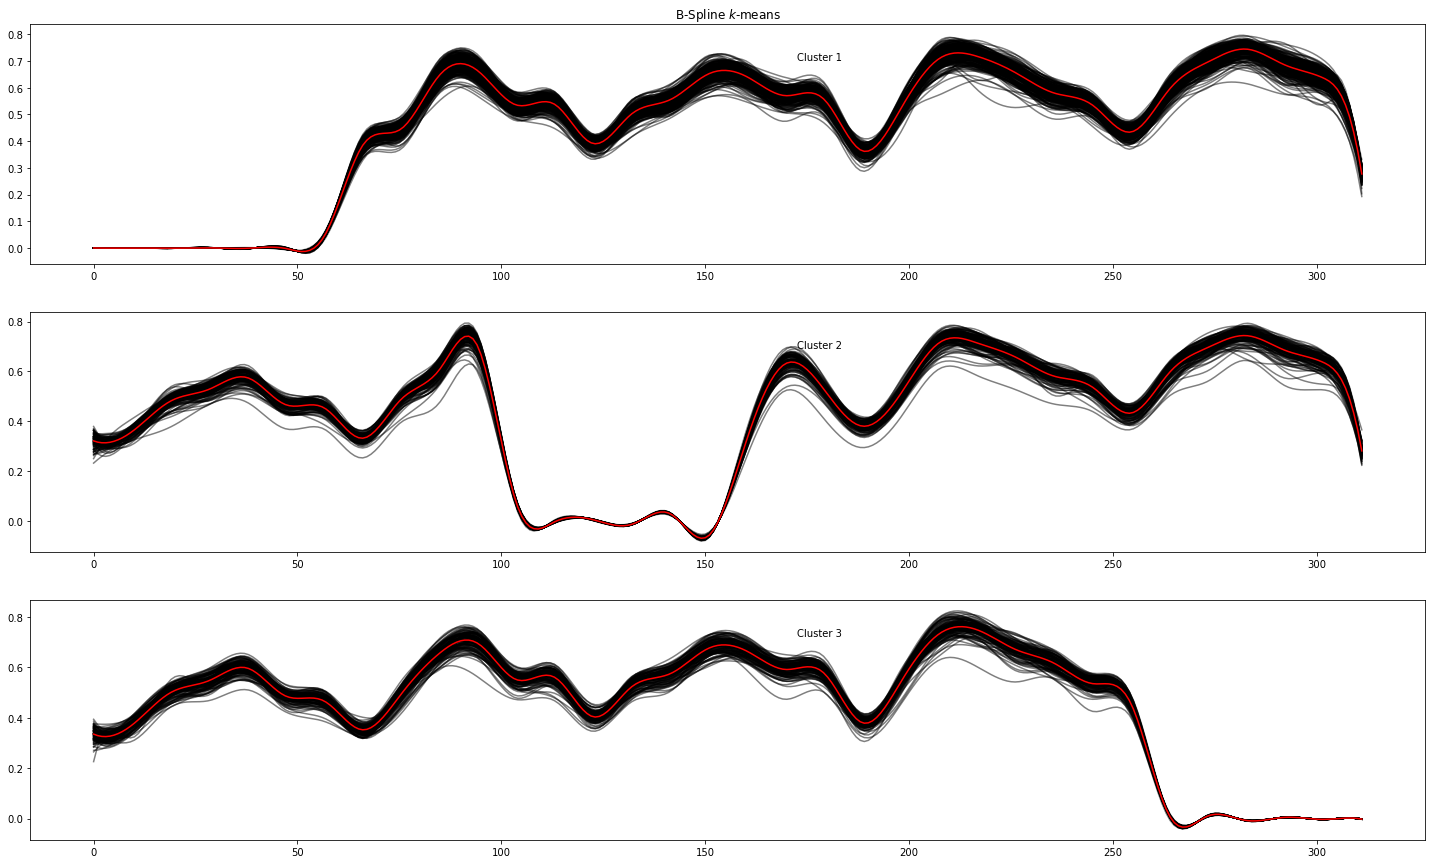

In [21]:
# Cluster Center 가져오기
fig = plt.figure(figsize=(25,15))
for i in range(3):
    plt.subplot(3, 1, i+1)
    for xx in output_fin.filter(output_fin.prediction==i).select('bs_fake_sales').collect():
        plt.plot(np.dot(basis,np.array(xx).T).ravel(), "k-", alpha=.5)
    plt.plot(np.dot(basis, KMeans_fit.clusterCenters()[i]).ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
             transform=plt.gca().transAxes)
    if i == 0:
        plt.title("B-Spline $k$-means")
plt.show()

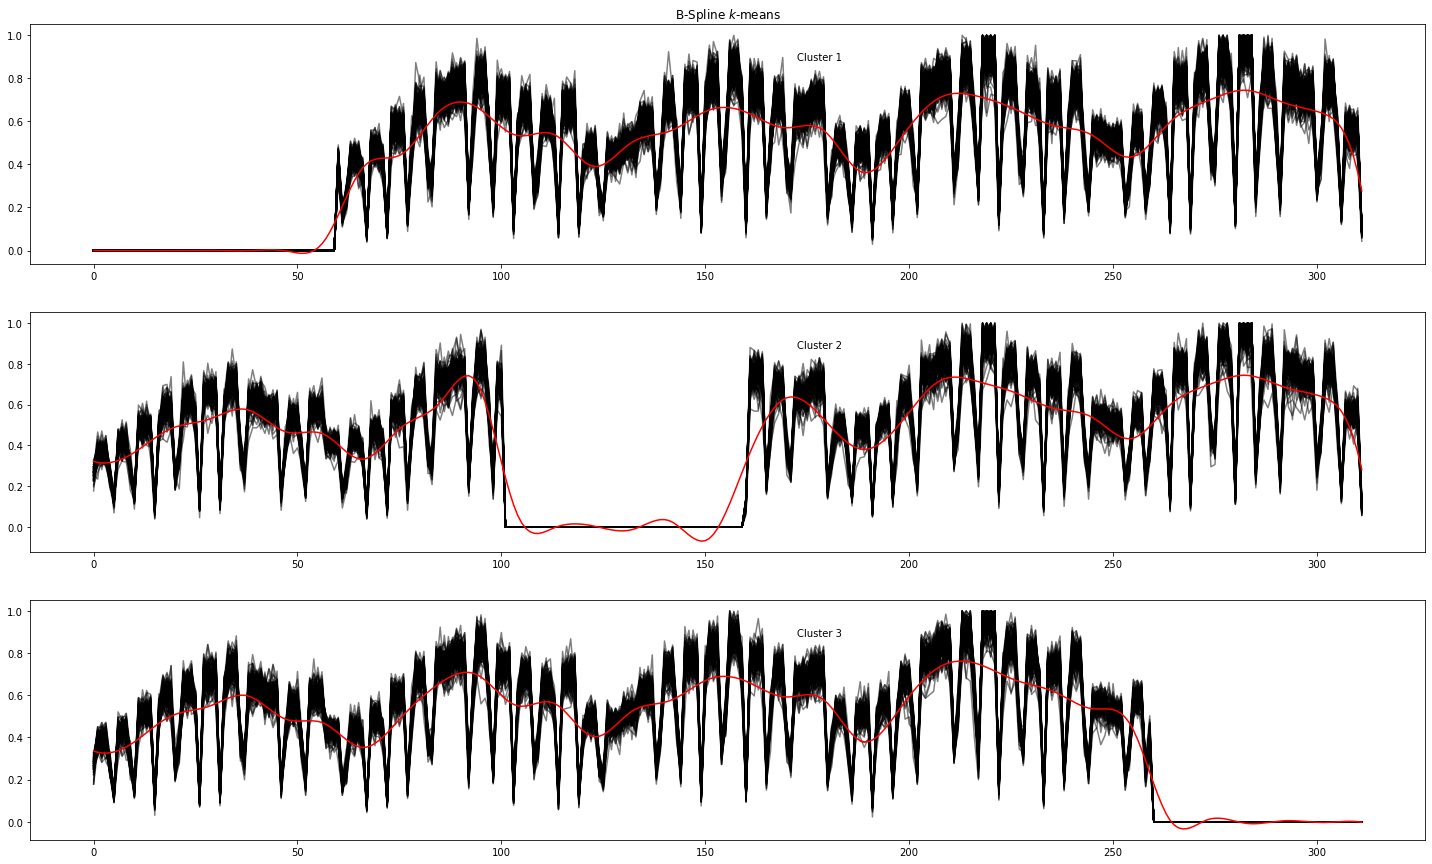

In [22]:
fig = plt.figure(figsize=(25,15))
for i in range(3):
    plt.subplot(3, 1, i+1)
    for xx in output_fin.filter(output_fin.prediction==i).select('scaled_fake_sales').collect():
        plt.plot(np.array(xx).ravel(), "k-", alpha=.5)
    plt.plot(np.dot(basis, KMeans_fit.clusterCenters()[i]).ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (i + 1),
             transform=plt.gca().transAxes)
    if i == 0:
        plt.title("B-Spline $k$-means")
plt.show()

In [49]:
from collections import Counter
print(Counter(np.array(output_fin.select('prediction').collect()).flatten()))

Counter({0: 262, 1: 119, 2: 119})


In [33]:
import plotly
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# DTW 하이퍼 파라미터들 값 지정
def objectiveDTW(trial: Trial, X):
    param = {
        'n_clusters' : trial.suggest_int('n_clusters', 2, 10),
        'n_jobs' : -1,
        'max_iter' : 10,
        'metric' : trial.suggest_categorical('metric', ['dtw','softdtw'])
    }
    
    # 학습 모델 생성
    model = TimeSeriesKMeans(**param)
    dtw = model.fit(X) # 학습 진행
    
    # 모델 성능 확인
    score = silhouette_score(X, dtw.predict(X), metric='softdtw', n_jobs=-1)
    
    return score
# 실루엣 계수가 최소가 되는 방향으로 학습을 진행
# TPESampler : Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
study = optuna.create_study(direction='maximize', sampler=TPESampler())

# n_trials 지정해주지 않으면, 무한 반복
study.optimize(lambda trial : objectiveDTW(trial, np.array(t_kmeans.select('scaled_fake_sales').collect()).reshape(500,312)), n_trials = 50)

print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-05-22 12:27:05,536] A new study created in memory with name: no-name-09a6132b-27cd-4304-a6df-463adaf5beb9
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.

0.667 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.378 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.378 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.378 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.378 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.378 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.378 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.378 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[I 2022-05-22 12:35:06,125] Trial 0 finished with value: 0.990737937

Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster


[I 2022-05-22 12:50:52,169] Trial 1 finished with value: 0.6389662354488689 and parameters: {'n_clusters': 7, 'metric': 'softdtw'}. Best is trial 0 with value: 0.990737937803385.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs

0.591 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.2s finished


0.342 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.2s finished


0.342 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.2s finished


0.342 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.2s finished


0.342 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.342 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.342 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_job

Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster


[I 2022-05-22 13:18:21,637] Trial 3 finished with value: 0.9021541819036376 and parameters: {'n_clusters': 8, 'metric': 'softdtw'}. Best is trial 0 with value: 0.990737937803385.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent worker

1.283 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.697 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.697 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.697 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.697 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.697 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.697 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[I 2022-05-22 13:26:23,562] Trial 4 finished with value: 0.7136194289603013 and parameters: {'n_clusters': 2, 'metric': 'dtw'}. Best is trial 0 with value: 0.990737937803385.
[Parallel(n_jobs=-1

0.545 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[I 2022-05-22 13:34:19,981] Trial 5 finished with value: 0.990737937

Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster


[I 2022-05-22 13:55:20,245] Trial 6 finished with value: 0.8143840079127591 and parameters: {'n_clusters': 9, 'metric': 'softdtw'}. Best is trial 0 with value: 0.990737937803385.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs

0.571 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.346 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.342 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.334 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.333 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.332 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.332 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.3s finished


0.332 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.3s finished


0.332 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.3s finished


0.332 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_job

Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster


[I 2022-05-22 14:25:21,967] Trial 8 finished with value: 0.4563755351023294 and parameters: {'n_clusters': 9, 'metric': 'softdtw'}. Best is trial 0 with value: 0.990737937803385.


Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster


[I 2022-05-22 14:40:06,908] Trial 9 finished with value: 0.6205969972962089 and parameters: {'n_clusters': 6, 'metric': 'softdtw'}. Best is trial 0 with value: 0.990737937803385.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent worker

1.193 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.709 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.644 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.644 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.644 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.644 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.644 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.644 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[I 2022-05-22 14:48:25,601] Trial 10 finished with value: 0.7136194289603013 and parameters: {'n_clusters': 2, 'metric': 'dtw'}. Best is trial 0 with value: 0.990737937803385.
[Parallel(n_jobs=-

0.543 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.365 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.363 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.362 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.361 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.2s finished


0.361 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.360 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.360 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.360 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_job

0.536 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[I 2022-05-22 15:04:54,187] Trial 12 finished with value: 0.99073793

0.503 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.343 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.341 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.340 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.340 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.340 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.340 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.340 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.2s finished


0.340 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_job

0.543 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.375 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.375 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.375 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.375 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[I 2022-05-22 15:21:12,662] Trial 14 finished with value: 0.99073793

0.457 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


0.326 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


0.323 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


0.322 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


0.322 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.3s finished


0.322 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


0.322 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


0.322 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


0.322 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished


0.321 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_job

2.249 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.762 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.762 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.762 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.762 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.762 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[I 2022-05-22 15:37:29,603] Trial 16 finished with value: 0.738985905523925 and parameters: {'n_clusters': 2, 'metric': 'dtw'}. Best is trial 0 with value: 0.990737937803385.
[Parallel(n_jobs=-1

0.487 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.340 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.337 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.336 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.334 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.334 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.334 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.334 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.334 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.334 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_job

0.661 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[I 2022-05-22 15:53:40,078] Trial 18 finished with value: 0.99073793

0.414 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.4s finished


0.300 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished


0.297 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished


0.296 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished


0.295 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished


0.294 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished


0.294 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished


0.294 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished


0.294 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished


0.294 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_j

0.553 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.3s finished


0.328 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.327 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.326 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.326 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.326 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.326 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished


0.326 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_job

0.554 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.375 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.375 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.375 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.375 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[I 2022-05-22 16:18:19,386] Trial 21 finished with value: 0.99073793

0.695 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished


0.376 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    0.1s finished
[I 2022-05-22 16:26:26,613] Trial 22 finished with value: 0.99073793

0.600 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.342 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.342 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.341 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.341 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.341 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.341 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished


0.341 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:    0.1s
[Parallel(n_job

1.352 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.797 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.725 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.640 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.639 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.639 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.639 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.639 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.639 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


0.639 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


KeyboardInterrupt: 

In [34]:
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

Best trial : score 0.990737937803385, 
params {'n_clusters': 3, 'metric': 'dtw'}


In [36]:
optuna.visualization.plot_param_importances(study) # 파라미터 중요도 확인 그래프
optuna.visualization.plot_optimization_history(study) # 최적화 과정 시각화

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23],
              'y': [0.990737937803385, 0.6389662354488689, 0.8100593361471526,
                    0.9021541819036376, 0.7136194289603013, 0.990737937803385,
                    0.8143840079127591, 0.7118941765984087, 0.4563755351023294,
                    0.6205969972962089, 0.7136194289603013, 0.8967255654895391,
                    0.990737937803385, 0.8205593622915103, 0.990737937803385,
                    0.7280615350184755, 0.738985905523925, 0.7527696845590905,
                    0.990737937803385, 0.3062598480262369, 0.6917891938738954,
                    0.990737937803385, 0.990737937803385, 0.8041900784819099]},
             {'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23],
              'y': array([0.99073794, 0.99073794, 0.99073794, 0.99073794, 0.99073794, 0.99073794,
                          0.99073794, 0.99073794, 0.99073794, 0.99073794, 0.99073794, 0.99073794,
                          0.99073794, 0.99073794, 0.99073794, 0.99073794, 0.99073794, 0.99073794,
                          0.99073794, 0.99073794, 0.99073794, 0.99073794, 0.99073794, 0.99073794])}],
    'layout': {'template': '...',
               'title': {'text': 'Optimization History Plot'},
               'xaxis': {'title': {'text': '#Trials'}},
               'yaxis': {'title': {'text': 'Objective Value'}}}
})

In [82]:
# 베이지안 하이퍼파라미터 조정

from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization


def val(n_clusters):
    dtw = TimeSeriesKMeans(n_clusters=int(n_clusters), metric='softdtw', n_jobs=-1, max_iter=10, verbose=1)
    pred_y = dtw.fit_predict(ts_lst)
    score = silhouette_score(ts_lst, pred_y, metric='softdtw', n_jobs=-1, verbose=1)
     
    return score
 
optimizer = BayesianOptimization(f=val,
    pbounds={'n_clusters': (1,10)})
 
optimizer.maximize(init_points=2, 
                   n_iter=5)
 
print('best result:', optimizer.max)

d:\DS-etrade\mobis\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


|   iter    |  target   | n_clus... |
-------------------------------------
51526018924917.594 --> 14351670500366.871 --> 14337033065513.340 --> 14327914051145.947 --> 14321943510375.645 --> 14317382636338.861 --> 14199916356561.984 --> 14197635958064.920 --> 14195315078067.947 --> 14192971881279.119 --> 


KeyboardInterrupt: 

In [37]:
# pip install tslearn
# DTW clusering 모델 생성
from tslearn.clustering import TimeSeriesKMeans
ts_dtw_model = TimeSeriesKMeans(n_clusters=3,metric='softdtw', max_iter=10)
ts_dtw_model.fit(np.array(t_kmeans.select('scaled_fake_sales').collect()).reshape(500,312))
# ts_dtw_model.cluster_centers_.shape

TimeSeriesKMeans(max_iter=10, metric='softdtw')

In [38]:
ts_dtw_model2 = TimeSeriesKMeans(n_clusters=3,metric='dtw', max_iter=10)
ts_dtw_model2.fit(np.array(t_kmeans.select('scaled_fake_sales').collect()).reshape(500,312))

TimeSeriesKMeans(max_iter=10, metric='dtw')

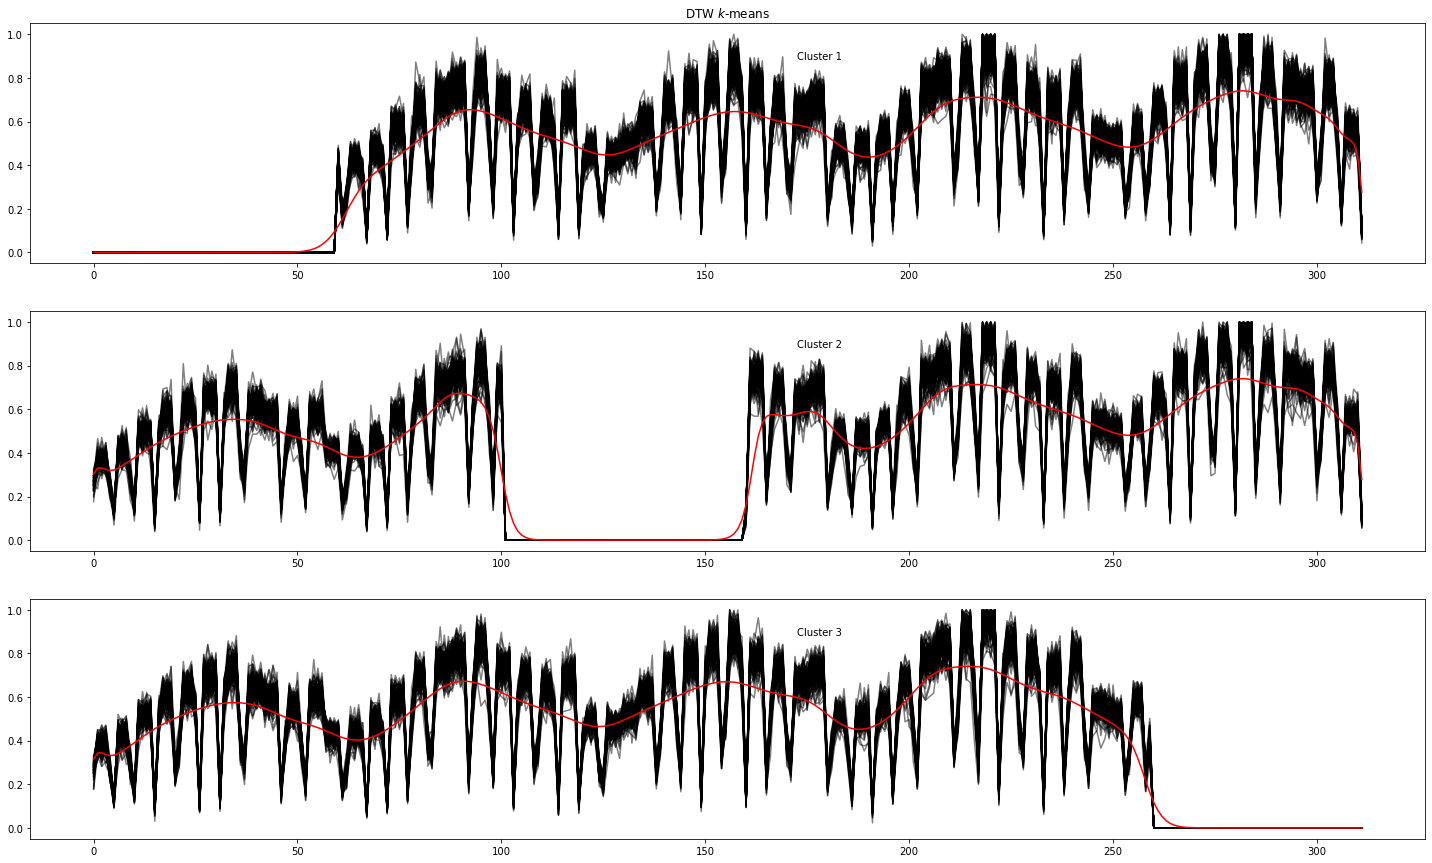

In [40]:
# DTW기반 KMeans 클러스터별 그래프
import numpy as np
import matplotlib.pyplot as plt
ts_lst = np.array(t_kmeans.select('scaled_fake_sales').collect()).reshape(500,312)
y_pred = ts_dtw_model.predict(ts_lst)

fig = plt.figure(figsize=(25,15))
for yi in range(3):
    plt.subplot(3, 1, yi+1)
    for xx in ts_lst[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.5)
    plt.plot(ts_dtw_model.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DTW $k$-means")
plt.show()

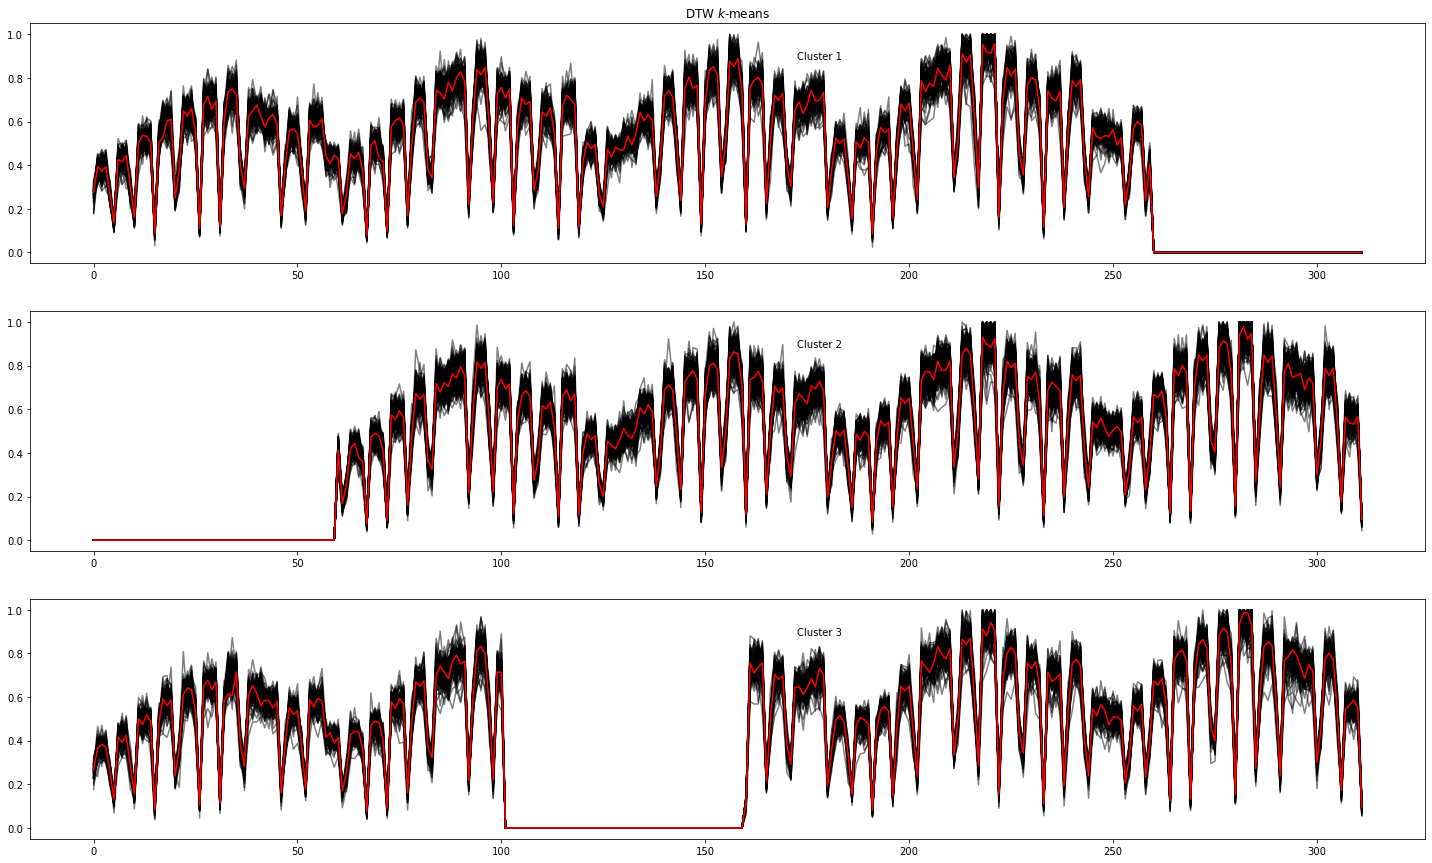

In [41]:
y_pred2 = ts_dtw_model2.predict(ts_lst)

plt.figure(figsize=(25,15))
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in ts_lst[y_pred2 == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.5)
    plt.plot(ts_dtw_model2.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DTW $k$-means")
plt.show()

In [42]:
# 클러스터별 기초 통계량 확인

from scipy import stats
print(Counter(y_pred))
for i in range(3):
    print(stats.describe(ts_lst[y_pred==i].flatten()))


Counter({0: 262, 1: 119, 2: 119})
DescribeResult(nobs=81744, minmax=(0.0, 1.0), mean=0.45980964654173034, variance=0.0901005992065785, skewness=-0.31810412855546866, kurtosis=-1.2147905808155448)
DescribeResult(nobs=37128, minmax=(0.0, 1.0), mean=0.44685764727247906, variance=0.08636354898131693, skewness=-0.2579767670042024, kurtosis=-1.1833198338864093)
DescribeResult(nobs=37128, minmax=(0.0, 1.0), mean=0.458105208109695, variance=0.08033640296299413, skewness=-0.3447178426784159, kurtosis=-1.0631926193667836)


In [43]:
# 클러스터별 기초통계량
print(Counter(y_pred2))
for i in range(3):
    print(stats.describe(ts_lst[y_pred2==i].flatten()))


Counter({1: 262, 2: 119, 0: 119})
DescribeResult(nobs=37128, minmax=(0.0, 1.0), mean=0.458105208109695, variance=0.08033640296299413, skewness=-0.3447178426784159, kurtosis=-1.0631926193667836)
DescribeResult(nobs=81744, minmax=(0.0, 1.0), mean=0.45980964654173034, variance=0.0901005992065785, skewness=-0.31810412855546866, kurtosis=-1.2147905808155448)
DescribeResult(nobs=37128, minmax=(0.0, 1.0), mean=0.44685764727247906, variance=0.08636354898131693, skewness=-0.2579767670042024, kurtosis=-1.1833198338864093)


In [52]:
output_fin.show()

+-----+----+--------------------+--------------------+----------+
|store|item|   scaled_fake_sales|       bs_fake_sales|prediction|
+-----+----+--------------------+--------------------+----------+
|    1|   1|[0.29326922, 0.32...|[0.33752514695351...|         1|
|    1|   2|[0.27554744, 0.40...|[0.35619763192084...|         2|
|    1|   3|[0.0, 0.0, 0.0, 0...|[2.4698558276145E...|         0|
|    1|   4|[0.2764977, 0.400...|[0.32029507451288...|         1|
|    1|   5|[0.2413793, 0.385...|[0.29531574197149...|         2|
|    1|   6|[0.0, 0.0, 0.0, 0...|[4.59187196059580...|         0|
|    1|   7|[0.2831216, 0.370...|[0.33856742228614...|         1|
|    1|   8|[0.3, 0.40140846,...|[0.35822011700424...|         2|
|    1|   9|[0.0, 0.0, 0.0, 0...|[2.81960590746521...|         0|
|    1|  10|[0.26911765, 0.38...|[0.34196404361884...|         1|
|    1|  11|[0.32164633, 0.37...|[0.35089019751769...|         2|
|    1|  12|[0.0, 0.0, 0.0, 0...|[1.24767919394248...|         0|
|    1|  1

In [55]:
week_si_df.show()

+----+-----+----+-----+----+----------+-----------+
|year|month|week|store|item|week_sales|week_stdate|
+----+-----+----+-----+----+----------+-----------+
|2013|    1|   1|    1|   1|        61| 2013-01-01|
|2013|    1|   1|    1|   2|       151| 2013-01-01|
|2013|    1|   1|    1|   3|        92| 2013-01-01|
|2013|    1|   1|    1|   4|        60| 2013-01-01|
|2013|    1|   1|    1|   5|        42| 2013-01-01|
|2013|    1|   1|    1|   6|       135| 2013-01-01|
|2013|    1|   1|    1|   7|       156| 2013-01-01|
|2013|    1|   1|    1|   8|       213| 2013-01-01|
|2013|    1|   1|    1|   9|       117| 2013-01-01|
|2013|    1|   1|    1|  10|       183| 2013-01-01|
|2013|    1|   1|    1|  11|       211| 2013-01-01|
|2013|    1|   1|    1|  12|       200| 2013-01-01|
|2013|    1|   1|    1|  13|       212| 2013-01-01|
|2013|    1|   1|    1|  14|       146| 2013-01-01|
|2013|    1|   1|    1|  15|       206| 2013-01-01|
|2013|    1|   1|    1|  16|        74| 2013-01-01|
|2013|    1|

- 상한, 하한 설정 방법

1. 볼린저 밴드 활용: 기본 20일 이평선 +- 2*sigma 

2. ucl, lcl 활용: n개 데이터의 평균 +- 3*sigma

- 평가 지표

SMAPE 활용
